### First Homework, AI applications with GAN, Sprint 2021, CSTU

##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras.layers import LeakyReLU


In [3]:
tf.keras.backend.clear_session()

In [4]:
tf.test.is_built_with_cuda()

True

In [5]:
print(tf.version.VERSION)

2.4.1


In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [7]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [8]:
print (data_dir)
#use cmd + shift + [.] to see hidden file/dir
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
# paths = list(data_dir.glob('*/'))
# print(paths)

C:\Users\rober\.keras\datasets\flower_photos
3670


Here are some roses:

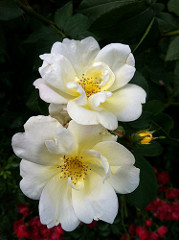

In [9]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

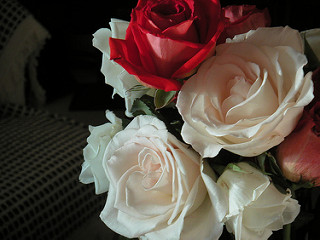

In [10]:
PIL.Image.open(str(roses[1]))

And some tulips:

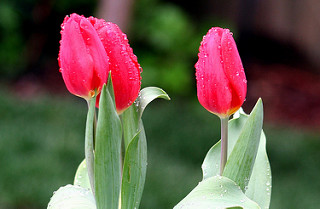

In [11]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

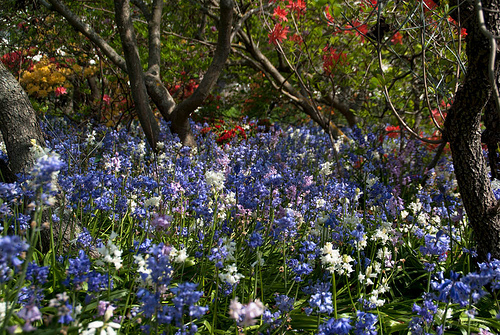

In [12]:
PIL.Image.open(str(tulips[1]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [13]:
batch_size = 64
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
#    color_mode="grayscale",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
#    color_mode="grayscale",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [16]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first 9 images from the training dataset.

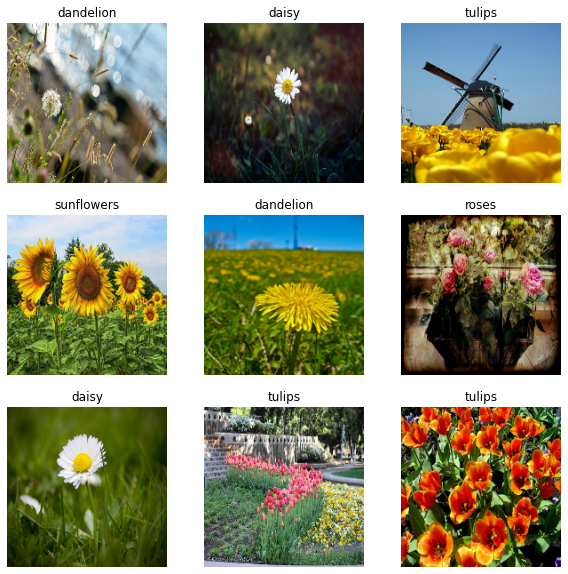

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [20]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.9931374


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

In [22]:
# dategen=ImageDataGenerator()
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(-0.5),
    
  ]
)


In [23]:
# visualize examples

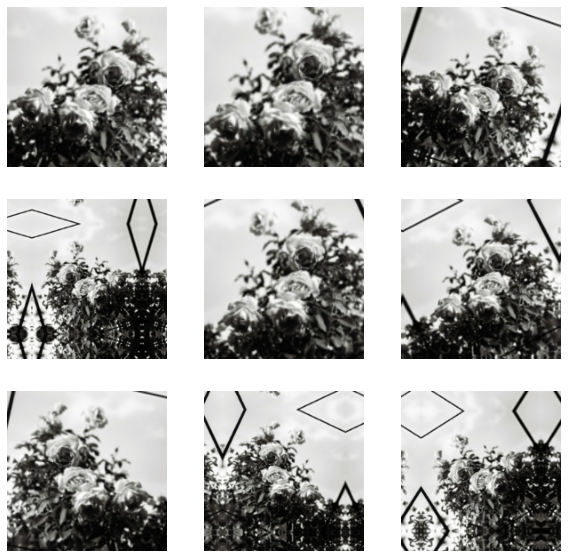

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [25]:
num_classes = 5

model = Sequential([
### ADD AUGMENTATION HERE
### BEGIN
#    layers.InputLayer(input_shape=(img_height,img_width,4)),
#    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,4)),
#    data_augmentation,
#        layers.experimental.preprocessing.PreprocessingLayer(input_shape=(img_height,img_width,1)),
#        layers.experimental.preprocessing.Rescaling(1./255),
#        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_shape)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(-0.5),
    
### END
    layers.Conv2D(16, 3, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
#    layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'), # replace MaxPooling with Strides = 2 Conv2D
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
### ADD DROP OUT LAYER HERE
### BEGIN 
#    layers.Dropout(0.2),
    layers.Dropout(0.5),
#    layers.Dropout(1.0),
### END
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.add

<bound method Sequential.add of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001845FCB3850>>

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [26]:
### ADD learning rate to ADAM optimizer
### Hint: use optimizer instance name instead of string "adam"
### optimizer=tf.keras.optimizers.Adam(lr)
### BEGIN
#  optimizer='adam',
### END
"""

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
#    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
"""


"\n\nmodel.compile(\n    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),\n#    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),\n#    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),\n    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n    metrics=['accuracy'])\n"

## Model summary

View all the layers of the network using the model's `summary` method:

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 4)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 180, 180, 4)       0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 180, 180, 4)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      592       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 16)      64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)       

In [28]:
import datetime
EXP_NAME='classifier_flower'
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/%s/gradient_tape/'%EXP_NAME + current_time + '/flower'
summary_writer = tf.summary.create_file_writer(log_dir)


## Train the model

In [29]:
epochs=60
loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')
optimizer = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9)

train_losses = []
train_acc = []
valid_losses = []
valid_acc = []


def reset_states():
    train_loss.reset_states()
    train_accuracy.reset_states()
    valid_loss.reset_states()
    valid_accuracy.reset_states()

@tf.function
def train_step(image,label):
    with tf.GradientTape() as tape:
        pred=model(image, training=True)
        loss=loss_function(label,pred)
    gradients=tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(label, pred)
    
@tf.function
def valid_step(image,label):
    pred=model(image, training=False)
    loss=loss_function(label,pred)
    valid_loss(loss)
    valid_accuracy(label, pred)    
    
reset_states()

for epoch in range(epochs):
    i=0
#    reset_states()
    for image, label in train_ds:
        image_new = tf.image.rgb_to_grayscale(image)
        image = tf.keras.layers.concatenate([image,image_new], axis=3)
        train_step(image,label)
        i+=1
    for image, label in val_ds:
        image_new = tf.image.rgb_to_grayscale(image)
        image = tf.keras.layers.concatenate([image,image_new], axis=3)
        valid_step(image,label)
        i+=1
    print("{}: train loss/acc:{:.2}/{:.2}, valid loss/acc: {:.2}/{:.2}".format(epoch,
                                                                     train_loss.result(),
                                                                     train_accuracy.result(),
                                                                     valid_loss.result(),
                                                                     valid_accuracy.result()
                                                                 ))
    train_losses.append(train_loss.result())
    train_acc.append(train_accuracy.result()) 
    valid_losses.append(valid_loss.result())
    valid_acc.append(valid_accuracy.result())   
    with summary_writer.as_default():
      tf.summary.scalar('train_loss', train_loss.result(), step=epoch)   
      tf.summary.scalar('train_accuracy', train_accuracy.result(), step=epoch)   
      tf.summary.scalar('val_loss', valid_loss.result(), step=epoch)   
      tf.summary.scalar('val_accuracy', valid_accuracy.result(), step=epoch)   
        

InternalError: Blas GEMV launch failed:  m=3, n=2073600 [Op:MatMul]

## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

loss = train_losses
val_loss = valid_losses
acc = train_acc
val_acc = valid_acc

#acc = np.array(acc)
#val_acc = np.array(val_acc)
#loss = np.array(loss)
#val_loss = np.array(val_loss)
#print(val_acc.shape)
#print(acc.shape)
#print(val_loss.shape)
#print(loss.shape)

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
    subset="training",
  seed=123,
#    color_mode = "grayscale",
  image_size=(img_height, img_width),
  batch_size=600)

for image, label in test_ds:
    image_new = tf.image.rgb_to_grayscale(image)
    image = tf.keras.layers.concatenate([image,image_new], axis=3)
    d3_input=model(image).numpy()
    #print(tf.reduce_mean(d3_input,axis=0))
    colors=['red','blue','lightgreen','grey','cyan']
    cnt=[len(d3_input[label[:1000] == k,0]) for k in range(5)]
    print ("freq of 5 classes:", cnt)
    for i,k in enumerate(zip(class_names, colors)):   
      print (i, k)
    for k in range(5):   
      plt.scatter(d3_input[label[:1000] == k,0],d3_input[label[:1000]==k,1],c=colors[k])
    plt.show()
    

In [ ]:

### YOUR CODE HERE
#download 10 flower images from internet and prediction using your final model.
#What is the confidence for prediction results for each class?
###BEGIN
###END

In [ ]:
import glob
flower_path = ['test_images/test_images_%d.jpg'%i for i in range(0,11,1)]
labels = ['daisy', 'daisy', 'daisy', 'daisy', 'roses','roses','dandelion','dandelion', 'sunflower','sunflower','tulip']

i=0
#for in glob.glob(flower_path+'/*'):
for f in flower_path:
    print(f)
    img = keras.preprocessing.image.load_img(
#        f, color_mode="grayscale", target_size=(img_height, img_width,)
    f, color_mode="rgb", target_size=(img_height, img_width,)
    )

    img_array = keras.preprocessing.image.img_to_array(img)
#    print(img_array.shape)
    image_new = tf.image.rgb_to_grayscale(img_array)
    img_array = tf.keras.layers.concatenate([img_array,image_new], axis=-1)
    print(img_array.shape)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    layer=tf.keras.layers.experimental.preprocessing.RandomZoom(-0.5)
    img_array=layer(img_array)
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    plt.imshow(img_array[0].numpy().astype("uint8"))
    plt.show()
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    for k in range(5):
        print(
            "  {} with a {:.2f} % confidence"
            .format(class_names[k], 100 * score[k])
        )
        
    i+=1
    

In [ ]:
### Your code here, 
#Generate the confusion matrix (5x5) for all data sets (3670 samples) and explain 
# A) which class has the highest precision and lower precision. 
# B) which class has the highest accuracy and lowest accuracy.
#What is the overall accuracy for the test?   
##Hint: tf.math.confusion_matrix
### BEGIN
prediction_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
#  validation_split=0.99,
#    subset="training",
  seed=123,
#    color_mode = "rgb",
  image_size=(img_height, img_width)
  )

def predict(f):
    img = keras.preprocessing.image.load_img(
        f, target_size=(img_height, img_width)
    )
    image_array = keras.preprocessing.image.img_to_array(img)
#    print(img_array.shape)
    img_new = tf.image.rgb_to_grayscale(image_array)
#    print(img_new.shape)
    img_array = tf.keras.layers.concatenate([image_array,img_new], axis=-1)
#    print(img_array.shape)
#    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    p = np.argmax(score)
    return p

rlist=[]
plist=[]
for label in range(0, len(class_names)):
  dir = class_names[label]
#  print(dir)
  path = dir+'/*.jpg'
  print(path)
  flist= list(data_dir.glob(path))
  count=0
  for f in flist:
    plist.append(predict(f))
    rlist.append(label)
#    print(plist)
    count +=1
    if count ==len(flist):
      count = 0
  
#  print(plist)
#  print("plist lenth:", len(plist))
#  print(rlist)
#  print("rlist Length:", len(rlist))
  print('label=', label)
  print("number of images:", len(flist))

cfm=tf.math.confusion_matrix(rlist, plist)
print(f'confusion matrix:\n{cfm}')
"""
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
accuracy_score(rlist, plist)
precision_score(rlist, plist)
"""
### END
